In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel import GaussianKernel
from torchcps.kernel_cnn import KernelConv, KernelMap, KernelMix, KernelPool

In [3]:
# create a datset of 2D signals with noise
n_samples = 10000
n_dimensions = 2
n_measurements = 10

with torch.no_grad():
    targets = 50 * torch.rand(n_samples, n_dimensions) - 25
    # convert to polar coordinates
    targets_range = torch.norm(targets, dim=-1)
    targets_bearing = torch.atan2(targets[..., 1], targets[..., 0])
    # add noise to make measurements
    measurements_range = (
        targets_range[..., None] + torch.randn(n_samples, n_measurements) * 1.0
    )
    measurements_bearing = (
        targets_bearing[..., None] + torch.randn(n_samples, n_measurements) * 0.5
    )
    # convert back to cartesian coordinates
    measurements = torch.stack(
        [
            measurements_range * torch.cos(measurements_bearing),
            measurements_range * torch.sin(measurements_bearing),
        ],
        dim=-1,
    )

In [4]:
# evaluate naive strategy of taking mean of measurements
input_mean = measurements.mean(dim=1)
(input_mean - targets).pow(2).mean()

tensor(7.4230)

In [5]:
class UnpackTuple(nn.Module):
    def forward(self, input):
        return input[0], input[1]


n_channels = 1
max_kernels = 32
n_weights = 32
filter_kernels = 9
fixed_positions = True
pool_strategy = "largest"
sigma = [0.5, 2.0, 5.0, 2.0, 0.5]
nonlinearity = nn.LeakyReLU(0.1)


def model_factory():
    n_layers = len(sigma)
    layers: list[nn.Module] = [UnpackTuple()]
    for l in range(n_layers):
        first_layer = l == 0
        last_layer = l == n_layers - 1
        layers += [
            KernelConv(
                filter_kernels=filter_kernels,
                in_channels=n_channels if not first_layer else 1,
                out_channels=n_channels if not last_layer else 1,
                n_dimensions=2,
                kernel_spread=sigma[l],
                fixed_positions=fixed_positions,
                n_weights=n_weights if not first_layer else 1,
            ),
            KernelMix(
                kernel=GaussianKernel(sigma[l]),
                in_weights=n_weights if not first_layer else 1,
                out_weights=n_weights if not last_layer else 1,
            ),
            KernelMap(nonlinearity),
            KernelPool(max_kernels, strategy="largest"),
        ]
    layers = [l for l in layers if l is not None]
    return nn.Sequential(*layers)

In [6]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(measurements.cuda(), targets.cuda())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = model_factory().cuda()
optimizer = AdamW(model.parameters(), lr=1e-2, weight_decay=0)
mse_values = []

for i in range(5):
    pbar = tqdm(dataloader, total=len(dataloader))
    for x, y in pbar:
        x = x[:, None, ...]
        y = y[:, None, None, :]
        x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
        y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]
        z, z_weights = model((x, x_weights))

        kernel = GaussianKernel(sigma[-1])
        mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()
        mse_values.append(mse.item())
        pbar.set_postfix(loss=mse.item())

        mse.backward()
        optimizer.step()
        optimizer.zero_grad()

/home/damow/.pyenv/versions/3.11.4/envs/torchcps/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/625 [00:00<?, ?it/s]

1.0


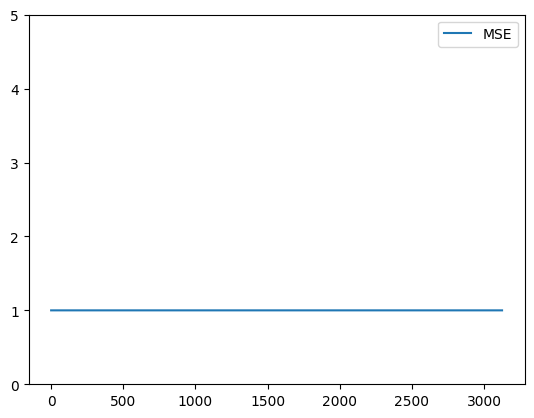

In [ ]:
print(np.mean(mse_values[-10:]))

plt.figure()
plt.plot(mse_values, label="MSE")
plt.legend()
plt.ylim(0, 5)
plt.show()

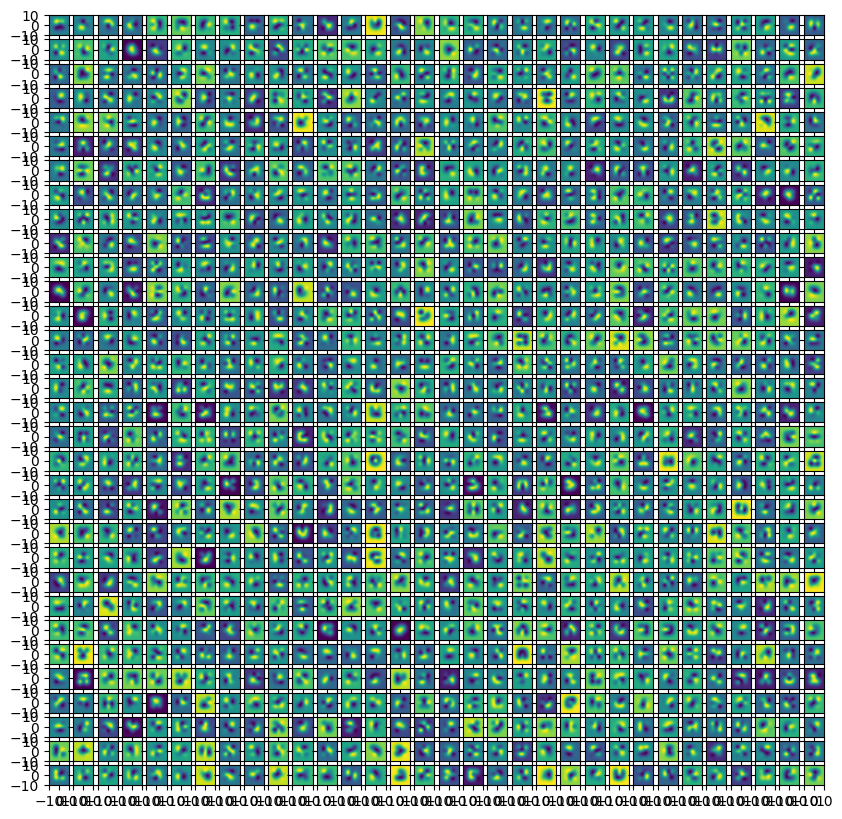

In [ ]:
from torchcps.kernel_cnn import RKHS


def raster_rkhs(X: RKHS, sigma: float, width: float, resolution: int):
    XY = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-width / 2, width / 2, resolution),
                torch.linspace(-width / 2, width / 2, resolution),
            ),
            dim=-1,
        )
        .reshape(-1, 2)
        .to(X.positions.device)
    )
    kernel = GaussianKernel(sigma)
    values = kernel(XY, X.positions) @ X.weights
    return values.reshape(resolution, resolution).detach().cpu().numpy()


# Plot the CNN Filter at the lth layer
l = 1
conv_layers = [layer for layer in model if isinstance(layer, KernelConv)]
positions = conv_layers[l].kernel_positions
weights = conv_layers[l].kernel_weights
in_channels, out_channels = positions.shape[:2]

fig, axs = plt.subplots(
    nrows=in_channels, ncols=out_channels, figsize=(10, 10), sharex=True, sharey=True
)
for i in range(in_channels):
    for j in range(out_channels):
        if in_channels == 1:
            ax = axs[j]
        elif out_channels == 1:
            ax = axs[i]
        else:
            ax = axs[i, j]
        rkhs = RKHS(positions[i, j], weights[i, j])
        width = sigma[l] * 10
        extent = np.array([-1, 1, -1, 1]) * width / 2
        ax.imshow(
            raster_rkhs(rkhs, sigma[l], width=width, resolution=128).T,
            extent=extent,
            origin="lower",
        )
plt.show()

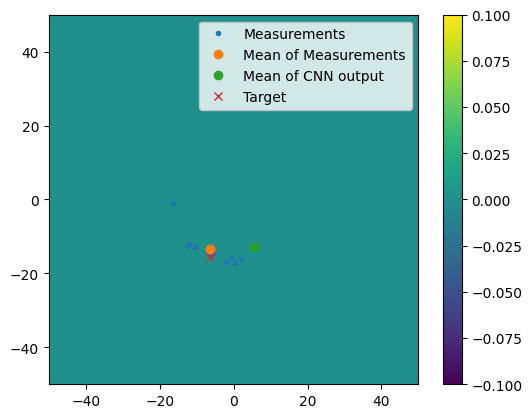

In [ ]:
idx = np.random.randint(0, n_samples)

with torch.no_grad():
    x = measurements[None, idx, None, ...].cuda()
    y = targets[None, idx, None, None, :].cuda()
    x_weights = torch.ones(*x.shape[:-1], device=x.device)
    y_weights = torch.ones(*y.shape[:-1], device=y.device)

    z, z_weights = model((x, x_weights))

    # squeeze all the tensors
    x = x.squeeze().cpu()
    y = y.squeeze().cpu()
    z = z.squeeze().cpu()
    z_weights = z_weights.squeeze().cpu()

    extent = [-50, 50, -50, 50]
    # extent = [y[0].item() - 10, y[0].item() + 10, y[1].item() - 10, y[1].item() + 10]
    XY = torch.stack(
        torch.meshgrid(
            [
                torch.linspace(-extent[0], extent[1], 1000),
                torch.linspace(-extent[0], extent[1], 1000),
            ]
        ),
        -1,
    ).reshape(-1, 2)
    kernel = GaussianKernel(sigma[-1])
    values = kernel(XY, z) @ z_weights
    values = values.reshape(1000, 1000).cpu().numpy()

    # naive way to make predictions
    input_mean = x.mean(0)
    # weigted mean of the cnn output
    output_mean = (z * z_weights[:, None]).sum(0) / z_weights.sum()

plt.figure()
plt.imshow(values.T, extent=extent, origin="lower")

plt.plot(*x.T, ".", label="Measurements")
plt.plot(*input_mean, "o", label="Mean of Measurements")
plt.plot(*output_mean, "o", label="Mean of CNN output")
plt.plot(*y, "x", label="Target")

plt.legend()
plt.colorbar()
plt.show()